In [1]:
from pathlib import Path
import time
import numpy as np
import torch

from data_loader import *
from model import *
from train import *
from val import *

# Path and data file name
folder  = Path.cwd().parent / 'Nyx'
DM_name = ['deltaDM_Nyx_L20_N160_z2.4.npy', 
            'vx_DM_Nyx_L20_N160_z2.4.npy',
            'vy_DM_Nyx_L20_N160_z2.4.npy',
            'vz_DM_Nyx_L20_N160_z2.4.npy']
ske_name_tra = 'spectra_Nyx_z2.4_z.npy'
ske_name_val = 'spectra_Nyx_z2.4_x.npy'
ske_name_tes = 'spectra_Nyx_z2.4_y.npy'



# hyper parameters
train_len  = 62500 # number of tau blocks
val_len    = 6250  # number of tau blocks
test_len   = 6250  # number of skewers
train_insize = np.array([11, 11, 59]) # x, y, z respctively
train_ousize = np.array([1, 1, 25]) # x, y, z respctively
batch_size = 50
learning_rate = 0.0005
num_epochs = 20
localtime = time.localtime()
if ~(train_insize%2).all():
    raise ValueError('train size cannot be even.')

# pre-process
def pre_proc(tau, block):
    '''log(tau), 97%'''
    tau_sum = tau.sum(axis=(-1,-2,-3))
    limit = np.percentile(tau_sum, 97)
    bln = tau_sum <= limit#np.ones(len(tau), 'bool')
    tau = np.log(tau)#np.log(np.exp(tau)-1)
    return (tau[bln],  block[bln])



# device used to train the model
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print('Using device:', torch.cuda.get_device_name(device=device.index))

Using device: Quadro P5000


In [2]:
# load dark matter data
print('Loading dark matter...')
DM_general_tra = load_DM(folder, DM_name)
DM_general_val = load_DM(folder, DM_name)
DM_general_val = DM_general_val.transpose(0,2,3,1)[[0,2,3,1]]

# basic paramters
DM_param.pix  = len(DM_general_tra[0])
DM_param.len  = 75 # in Mpc/h
DM_param.reso = DM_param.len / DM_param.pix # in Mpc/h
# test 
'''
if DM_general_tra.shape[1]<train_insize.min():
    raise ValueError('DarkMatter cube size',
        DM_general_tra.shape, 'is too small for train size', train_insize, '.')
DM_general_tra = torch.tensor(DM_general_tra).float()
DM_general_val = torch.tensor(DM_general_val).float()


# load skewers
print('Loading skewers...')
ske_tra, block_tra = load_skewers(folder, ske_name_tra, train_ousize, DM_param)
ske_val, block_val = load_skewers(folder, ske_name_val, train_ousize, DM_param)
# basic parameters
ske_len = int(ske_tra.shape[-1])
'''
ske_tra = np.load(zip

Loading dark matter...


"\n# basic paramters\nDM_param.pix  = len(DM_general_tra[0])\nDM_param.len  = 75 # in Mpc/h\nDM_param.reso = DM_param.len / DM_param.pix # in Mpc/h\n# test \nif DM_general_tra.shape[1]<train_insize.min():\n    raise ValueError('DarkMatter cube size',\n        DM_general_tra.shape, 'is too small for train size', train_insize, '.')\nDM_general_tra = torch.tensor(DM_general_tra).float()\nDM_general_val = torch.tensor(DM_general_val).float()\n\n\n# load skewers\nprint('Loading skewers...')\nske_tra, block_tra = load_skewers(folder, ske_name_tra, train_ousize, DM_param)\nske_val, block_val = load_skewers(folder, ske_name_val, train_ousize, DM_param)\n# basic parameters\nske_len = int(ske_tra.shape[-1])\n"

In [ ]:

new_arr = np.transpose(arr)
new_arr = new_arr[::-1]

In [3]:
# divide the sample to training, validation set, and test set.
print('Setting training and validation set...')
#id_seperate = divide_data(ske, train_ousize, , val_len, test_len, localtime)
id_seperate_tra = np.append(np.ones(train_len), np.zeros(ske_tra.shape[0]-train_len))
np.random.shuffle(id_seperate_tra)
id_seperate_val = np.append(np.ones(val_len), np.zeros(ske_val.shape[0]-val_len)) * 2
np.random.shuffle(id_seperate_val)

train_ske, train_block = load_train(ske_tra, block_tra, id_seperate_tra,
                                    train_ousize, batch_size, pre_proc)

val_ske, val_block = load_val(ske_val, block_val, id_seperate_val,
                              train_ousize, batch_size, pre_proc)

del id_seperate_tra, id_seperate_val


print('Loading model, loss, optimizer etc...')
# load model
from model import *
model = get_residual_network().float().to(device)
# loss and optimizer
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2)


# Train the model
curr_lr = learning_rate
start_time = time.time()
val_time   = localtime

lowest_losses = 9999.0
lowest_time   = localtime
tra_loss_l = np.array([])
val_loss_l = np.full(num_epochs, np.nan)

Setting training and validation set...
Loading model, loss, optimizer etc...


Text(0.5, 0, 'tau')

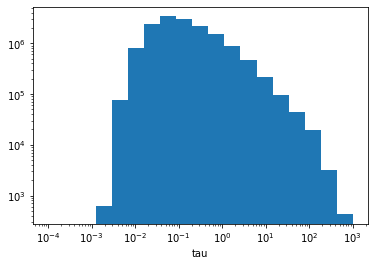

In [31]:
plt.hist(train_ske.flatten(), bins=np.logspace(-4, 3, 20, endpoint=True))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('tau')

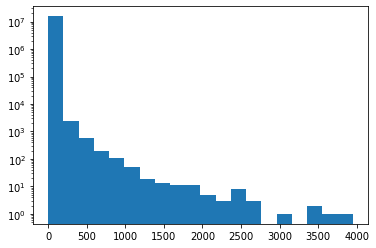

In [111]:
plt.hist(DM_general_tra[0].flatten(), bins=20);
plt.yscale('log')

In [116]:
DM_general_tra[0].min()

tensor(0.0213)

In [114]:
np.log(DM_general_tra[0].flatten()).min()

tensor(-3.8473)

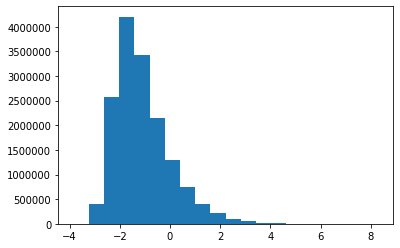

In [109]:
plt.hist(np.log(DM_general_tra[0].flatten()), bins=20);
#plt.yscale('log')

In [ ]:
scipy logit function

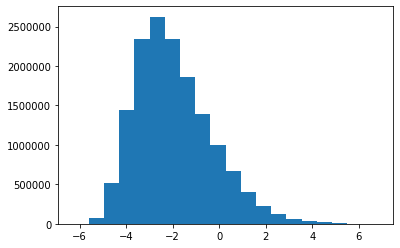

In [110]:
plt.hist((np.log(tau)), bins=20);

Text(0.5, 0, 'log(exp(tau)-1)')

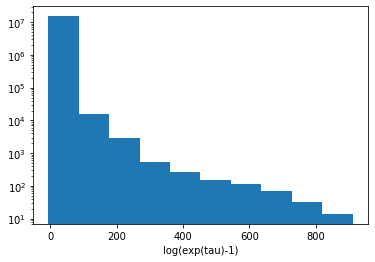

In [89]:
#plt.hist(train_ske.flatten(), bins=np.logspace(-4, 3, 20, endpoint=True))
tau = train_ske.flatten()
y = np.where(tau<50, np.log(np.exp(tau)-1), tau)
plt.hist(y)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('log(exp(tau)-1)')

In [4]:
model

ResNet(
  (conv1): Conv3d(4, 16, kernel_size=(3, 3, 7), stride=(1, 1, 1), bias=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv3d(16, 16, kernel_size=(3, 3, 7), stride=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv3d(16, 16, kernel_size=(1, 1, 9), stride=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Conv3d(16, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    )
    (1): ResidualBlock(
      (conv1): Conv3d(16, 16, kernel_size=(3, 3, 7), stride=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv3d(16, 16, kernel_size=(1, 1, 9), stride=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [5]:
model.train()

#for i, train_data in enumerate(train_ske, 0):
i = 0
train_data = train_ske[i]
train_size = train_insize
DM_general = DM_general_tra
# get the targets;
targets = train_data.to(device)
# x,y,z are the central coordinates of each input DM cuboid
x, y, z = train_block[(i*batch_size+np.arange(batch_size)).astype('int')].transpose()
# make coordinate index, retrieve input dark matter
batch_grids = make_batch_grids(x, y, z, batch_size, train_size, DM_param)
inputs = DM_general[batch_grids].to(device)

# forward + backward + optimize
outputs = model(inputs)


Start Training:
Begin Training Epoch 1
Epoch [ 1/20], Step [ 100/1212] Loss: 0.5483, Time: 15.3154
Epoch [ 1/20], Step [ 200/1212] Loss: 0.4825, Time: 29.8961
Epoch [ 1/20], Step [ 300/1212] Loss: 0.5779, Time: 44.3379
Epoch [ 1/20], Step [ 400/1212] Loss: 0.4196, Time: 59.1614
Epoch [ 1/20], Step [ 500/1212] Loss: 0.3399, Time: 72.9993
Epoch [ 1/20], Step [ 600/1212] Loss: 0.4660, Time: 87.3861
Epoch [ 1/20], Step [ 700/1212] Loss: 0.3369, Time: 101.5560
Epoch [ 1/20], Step [ 800/1212] Loss: 0.2688, Time: 115.8542
Epoch [ 1/20], Step [ 900/1212] Loss: 0.3239, Time: 130.2502
Epoch [ 1/20], Step [1000/1212] Loss: 0.2997, Time: 144.8263
Epoch [ 1/20], Step [1100/1212] Loss: 0.2272, Time: 157.3438
Epoch [ 1/20], Step [1200/1212] Loss: 0.2218, Time: 170.9365
Begin Validation @ Epoch 1
Step [ 100/1212] Loss: 0.5717, Time: 184.9441
Step [ 200/1212] Loss: 0.4801, Time: 197.0589
Step [ 300/1212] Loss: 0.5294, Time: 209.2366
Step [ 400/1212] Loss: 0.5849, Time: 219.9637
Step [ 500/1212] Loss: 

KeyboardInterrupt: 

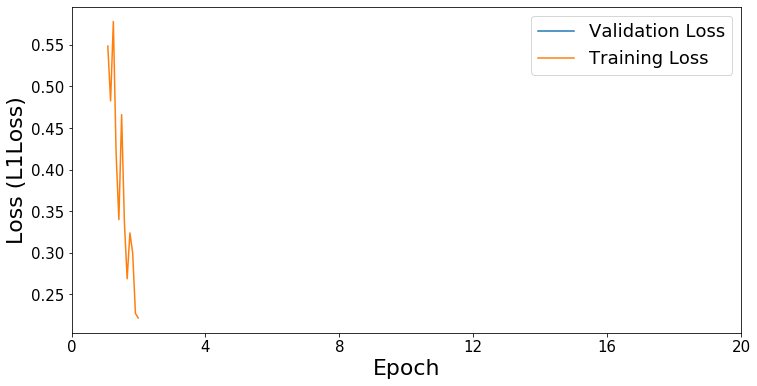

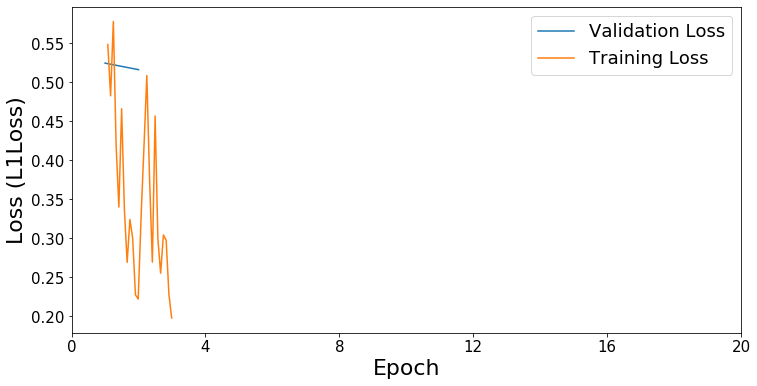

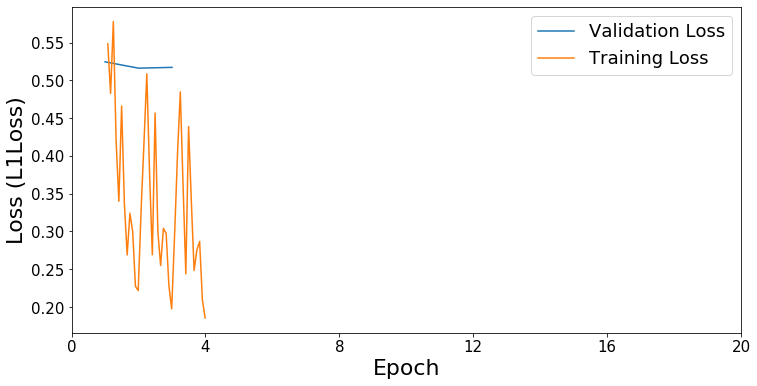

In [4]:
print('\nStart Training:')
with open('history.txt', 'a') as f:
    f.writelines('\n\n\nTraining History Record,')
    f.writelines('\nTime: '+time.strftime("%Y-%m-%d %H:%M:%S", localtime))
    f.writelines('\nTrain Frac: {}/{}'.format(len(train_ske.flatten()), len(ske_tra.flatten())))
    f.writelines('\nReal Train Frac: {}/{}'.format(len(train_ske.flatten()), len(ske_tra.flatten())))
    f.writelines('\nVal Frac: {}/{}'.format(len(val_ske.flatten()), len(ske_val.flatten())))
    f.writelines('\nReal Val Frac: {}/{}'.format(len(val_ske.flatten()), len(ske_val.flatten())))
    f.writelines('\nInput Size: %s'%str(train_insize))
    f.writelines('\nOutput Size: %s'%str(train_ousize))
    f.writelines('\nTraining Field: %s'%(pre_proc.__doc__))
    f.writelines('\nLoss: %s'%criterion.__class__.__name__)
    f.writelines('\nOptimizer: %s'%optimizer.__class__.__name__)
    f.writelines('\nLearning Rate: %s'%str(learning_rate))
f.close()


for epoch in range(num_epochs):
    # train for one epoch
    print("Begin Training Epoch {}".format(epoch+1))
    train_losses, tra_loss_l = train(train_ske, train_block, DM_general_tra, DM_param,
                    batch_size, train_insize, model, criterion, optimizer,
                    num_epochs, epoch, device, start_time, localtime, tra_loss_l)
    #tra_loss_l[epoch] = train_losses
    
    with open('history.txt', 'a') as f:
        f.writelines('\nEpoch {:{}d}/{}:'.format(epoch+1,
                                                 int(np.log10(num_epochs)+1), num_epochs))
        f.writelines('\n\tTraining loss : %s,  '%str(train_losses)\
            +time.strftime("%Y-%m-%d, %H:%M:%S", time.localtime()))
    f.close()

    # evaluate on validation set
    print("Begin Validation @ Epoch {}".format(epoch+1))
    val_losses = validate(val_ske, val_block, DM_general_val, DM_param,
                batch_size, train_insize, model, criterion, device, start_time)
    val_time   = time.localtime()
    val_loss_l[epoch] = val_losses
    
    fig = plt.figure(figsize=(12,6))
    plt.plot(np.arange(num_epochs)+1, val_loss_l, label='Validation Loss')
    plt.plot(tra_loss_l.reshape(-1,2)[:,0],
             tra_loss_l.reshape(-1,2)[:,1], label='Training Loss')
    plt.xticks(ticks=np.arange(6)*4, fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Epoch', fontsize=22)
    plt.ylabel('Loss ({})'.format(criterion.__class__.__name__), fontsize=22)
    plt.legend(fontsize=18);
    plt.savefig('loss_process.png', dpi=500, bbox_inches='tight')

    # remember best prec@1 and save checkpoint if desired
    # is_best = prec1 > best_prec1
    if val_losses < lowest_losses:
        lowest_losses = val_losses
        lowest_time   = val_time
        torch.save(model.state_dict(),
             "params/params_%s.pkl"%time.strftime("%Y-%m-%d_%H:%M:%S", localtime))
    '''
    else: model.load_state_dict(torch.load('params/params_%s.pkl'\
                %time.strftime("%Y-%m-%d_%H:%M:%S", localtime)))
    '''
    # reducing learning rate if val_losses do not reduce
    scheduler.step(val_losses)
    
    with open('history.txt', 'a') as f:
        f.writelines('\n\tValidation loss: %s,  '%str(val_losses)\
            +time.strftime("%Y-%m-%d, %H:%M:%S", val_time))
        f.writelines('\n\tLowest val loss: %s,  '%str(lowest_losses)\
            +time.strftime("%Y-%m-%d, %H:%M:%S", lowest_time))
    f.close()

    print("Epoch Summary: ")
    print("\tEpoch training loss: {}".format(train_losses))
    print("\tEpoch validation loss: {}".format(val_losses))
    print("\tLowest validation loss: {}".format(lowest_losses))    
    



'''
best_prec1 = 0

for epoch in range(num_epochs):
    # Set epoch count for DistributedSampler
    train_sampler.set_epoch(epoch)

    # Adjust learning rate according to schedule
    adjust_learning_rate(starting_lr, optimizer, epoch)

    # train for one epoch
    print("\nBegin Training Epoch {}".format(epoch+1))
    train(train_loader, model, criterion, optimizer, epoch)

    # evaluate on validation set
    print("Begin Validation @ Epoch {}".format(epoch+1))
    prec1 = validate(val_loader, model, criterion)

    # remember best prec@1 and save checkpoint if desired
    # is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)

    print("Epoch Summary: ")
    print("\tEpoch Accuracy: {}".format(prec1))
    print("\tBest Accuracy: {}".format(best_prec1))
'''

In [1]:
from pathlib import Path
import time
import numpy as np
import torch

from data_loader import *
from model import *
from train import *
from val import *

# Path and data file name
folder  = Path.cwd().parent / 'Nyx'
DM_name = ['deltaDM_Nyx_L20_N160_z2.4.npy', 
            'vx_DM_Nyx_L20_N160_z2.4.npy',
            'vy_DM_Nyx_L20_N160_z2.4.npy',
            'vz_DM_Nyx_L20_N160_z2.4.npy']
ske_name_tra = 'spectra_Nyx_z2.4_z.npy'
ske_name_val = 'spectra_Nyx_z2.4_x.npy'



# hyper parameters
train_len  = 62500 # number of tau blocks
val_len    = 6250  # number of tau blocks
test_len   = 0  # number of skewers
train_insize = np.array([11, 11, 93]) # x, y, z respctively
train_ousize = np.array([1, 1, 25]) # x, y, z respctively
batch_size = 50
learning_rate = 0.0005
num_epochs = 20
localtime = time.localtime()
if ~(train_insize%2).all():
    raise ValueError('train size cannot be even.')

# pre-process
def pre_proc(tau, block):
    '''log(tau), 97%'''
    tau_sum = tau.sum(axis=(-1,-2,-3))
    limit = np.percentile(tau_sum, 97)
    bln = tau_sum <= limit#np.ones(len(tau), 'bool')
    tau = np.log(tau)
    return (tau[bln],  block[bln])



# device used to train the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device:', torch.cuda.get_device_name(device=device.index))

# load dark matter data
print('Loading dark matter...')
DM_general_tra = load_DM(folder, DM_name)
DM_general_val = load_DM(folder, DM_name)
DM_general_val = DM_general_val.transpose(0,2,3,1)[[0,2,3,1]]

# basic paramters
DM_param.pix  = len(DM_general_tra[0])
DM_param.len  = 75 # in Mpc/h
DM_param.reso = DM_param.len / DM_param.pix # in Mpc/h
# test 
if DM_general_tra.shape[1]<train_insize.min():
    raise ValueError('DarkMatter cube size',
        DM_general_tra.shape, 'is too small for train size', train_insize, '.')
DM_general_tra = torch.tensor(DM_general_tra).float()
DM_general_val = torch.tensor(DM_general_val).float()


# load skewers
print('Loading skewers...')
ske_tra, block_tra = load_skewers(folder, ske_name_tra, train_ousize, DM_param)
ske_val, block_val = load_skewers(folder, ske_name_val, train_ousize, DM_param)
# basic parameters
ske_len = int(ske_tra.shape[-1])

# divide the sample to training, validation set, and test set.
print('Setting training and validation set...')
#id_seperate = divide_data(ske, train_ousize, , val_len, test_len, localtime)
id_seperate_tra = np.append(np.ones(train_len), np.zeros(ske_tra.shape[0]-train_len))
np.random.shuffle(id_seperate_tra)
id_seperate_val = np.append(np.ones(val_len), np.zeros(ske_val.shape[0]-val_len)) * 2
np.random.shuffle(id_seperate_val)

train_ske, train_block = load_train(ske_tra, block_tra, id_seperate_tra,
                                    train_ousize, batch_size, pre_proc)

val_ske, val_block = load_val(ske_val, block_val, id_seperate_val,
                              train_ousize, batch_size, pre_proc)



Using device: Quadro P6000
Loading dark matter...
Loading skewers...
Setting training and validation set...


In [4]:
train_block

array([[ 83., 223., 137.],
       [ 72., 118., 162.],
       [172., 200.,  87.],
       ...,
       [212., 221.,  62.],
       [112., 178.,  62.],
       [179.,  67.,  87.]])

In [ ]:
del id_seperate_tra, id_seperate_val


print('Loading model, loss, optimizer etc...')
# load model
model = get_residual_network().float().to(device)
# loss and optimizer
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2)


# Train the model
curr_lr = learning_rate
start_time = time.time()
val_time   = localtime

lowest_losses = 9999.0
lowest_time   = localtime
tra_loss_l = np.array([])
val_loss_l = np.full(num_epochs, np.nan)

print('\nStart Training:')
with open('history.txt', 'a') as f:
    f.writelines('\n\n\nTraining History Record,')
    f.writelines('\nTime: '+time.strftime("%Y-%m-%d %H:%M:%S", localtime))
    f.writelines('\nTrain Frac: {}/{}'.format(len(train_ske.flatten()), len(ske_tra.flatten())))
    f.writelines('\nReal Train Frac: {}/{}'.format(len(train_ske.flatten()), len(ske_tra.flatten())))
    f.writelines('\nVal Frac: {}/{}'.format(len(val_ske.flatten()), len(ske_val.flatten())))
    f.writelines('\nReal Val Frac: {}/{}'.format(len(val_ske.flatten()), len(ske_val.flatten())))
    f.writelines('\nInput Size: %s'%str(train_insize))
    f.writelines('\nOutput Size: %s'%str(train_ousize))
    f.writelines('\nTraining Field: %s'%(pre_proc.__doc__))
    f.writelines('\nLoss: %s'%criterion.__class__.__name__)
    f.writelines('\nOptimizer: %s'%optimizer.__class__.__name__)
    f.writelines('\nLearning Rate: %s'%str(learning_rate))
f.close()


for epoch in range(num_epochs):
    # train for one epoch
    print("Begin Training Epoch {}".format(epoch+1))
    train_losses, tra_loss_l = train(train_ske, train_block, DM_general_tra, DM_param,
                    batch_size, train_insize, model, criterion, optimizer,
                    num_epochs, epoch, device, start_time, localtime, tra_loss_l)
    #tra_loss_l[epoch] = train_losses
    
    with open('history.txt', 'a') as f:
        f.writelines('\nEpoch {:{}d}/{}:'.format(epoch+1,
                                                 int(np.log10(num_epochs)+1), num_epochs))
        f.writelines('\n\tTraining loss : %s,  '%str(train_losses)\
            +time.strftime("%Y-%m-%d, %H:%M:%S", time.localtime()))
    f.close()

    # evaluate on validation set
    print("Begin Validation @ Epoch {}".format(epoch+1))
    val_losses = validate(val_ske, val_block, DM_general_val, DM_param,
                batch_size, train_insize, model, criterion, device, start_time)
    val_time   = time.localtime()
    val_loss_l[epoch] = val_losses
    
    fig = plt.figure(figsize=(12,6))
    plt.plot(np.arange(num_epochs)+1, val_loss_l, label='Validation Loss')
    plt.plot(tra_loss_l.reshape(-1,2)[:,0],
             tra_loss_l.reshape(-1,2)[:,1], label='Training Loss', alpha=0.5)
    plt.xticks(ticks=np.arange(6)*4, fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Epoch', fontsize=22)
    plt.ylabel('Loss ({})'.format(criterion.__class__.__name__), fontsize=22)
    plt.legend(fontsize=18);
    plt.savefig('loss_process.png', dpi=500, bbox_inches='tight')

    # remember best prec@1 and save checkpoint if desired
    # is_best = prec1 > best_prec1
    if val_losses < lowest_losses:
        lowest_losses = val_losses
        lowest_time   = val_time
        torch.save(model.state_dict(),
             "params/params_%s.pkl"%time.strftime("%Y-%m-%d_%H:%M:%S", localtime))
    '''
    else: model.load_state_dict(torch.load('params/params_%s.pkl'\
                %time.strftime("%Y-%m-%d_%H:%M:%S", localtime)))
    '''
    # reducing learning rate if val_losses do not reduce
    scheduler.step(val_losses)
    
    with open('history.txt', 'a') as f:
        f.writelines('\n\tValidation loss: %s,  '%str(val_losses)\
            +time.strftime("%Y-%m-%d, %H:%M:%S", val_time))
        f.writelines('\n\tLowest val loss: %s,  '%str(lowest_losses)\
            +time.strftime("%Y-%m-%d, %H:%M:%S", lowest_time))
    f.close()

    print("Epoch Summary: ")
    print("\tEpoch training loss: {}".format(train_losses))
    print("\tEpoch validation loss: {}".format(val_losses))
    print("\tLowest validation loss: {}".format(lowest_losses))    
    



'''
best_prec1 = 0

for epoch in range(num_epochs):
    # Set epoch count for DistributedSampler
    train_sampler.set_epoch(epoch)

    # Adjust learning rate according to schedule
    adjust_learning_rate(starting_lr, optimizer, epoch)

    # train for one epoch
    print("\nBegin Training Epoch {}".format(epoch+1))
    train(train_loader, model, criterion, optimizer, epoch)

    # evaluate on validation set
    print("Begin Validation @ Epoch {}".format(epoch+1))
    prec1 = validate(val_loader, model, criterion)

    # remember best prec@1 and save checkpoint if desired
    # is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)

    print("Epoch Summary: ")
    print("\tEpoch Accuracy: {}".format(prec1))
    print("\tBest Accuracy: {}".format(best_prec1))
'''

In [ ]:
from pathlib import Path
import time
import numpy as np
import torch

from data_loader import *
from model import *
from train import *
from val import *

# Path and data file name
folder  = Path.cwd().parent / 'Nyx'
DM_name = ['deltaDM_Nyx_L20_N160_z2.4.npy', 
            'vx_DM_Nyx_L20_N160_z2.4.npy',
            'vy_DM_Nyx_L20_N160_z2.4.npy',
            'vz_DM_Nyx_L20_N160_z2.4.npy']
ske_name_tra = 'spectra_Nyx_z2.4_z.npy'
ske_name_val = 'spectra_Nyx_z2.4_x.npy'



# hyper parameters
train_len  = 62500 # number of tau blocks
val_len    = 6250  # number of tau blocks
test_len   = 0  # number of skewers
train_insize = np.array([11, 11, 93]) # x, y, z respctively
train_ousize = np.array([1, 1, 25]) # x, y, z respctively
batch_size = 50
learning_rate = 0.0005
num_epochs = 20
localtime = time.localtime()
if ~(train_insize%2).all():
    raise ValueError('train size cannot be even.')

# pre-process
def pre_proc(tau, block):
    '''log(tau), 97%'''
    tau_sum = tau.sum(axis=(-1,-2,-3))
    limit = np.percentile(tau_sum, 97)
    bln = tau_sum <= limit#np.ones(len(tau), 'bool')
    tau = np.log(tau)
    return (tau[bln],  block[bln])



# device used to train the model
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print('Using device:', torch.cuda.get_device_name(device=device.index))

# load dark matter data
print('Loading dark matter...')
DM_general_tra = load_DM(folder, DM_name)
DM_general_val = load_DM(folder, DM_name)[[0,3,2,1]]

# basic paramters
DM_param.pix  = len(DM_general_tra[0])
DM_param.len  = 75 # in Mpc/h
DM_param.reso = DM_param.len / DM_param.pix # in Mpc/h
# test 
if DM_general_tra.shape[1]<train_insize.min():
    raise ValueError('DarkMatter cube size',
        DM_general_tra.shape, 'is too small for train size', train_insize, '.')
DM_general_tra = torch.tensor(DM_general_tra).float()
DM_general_val = torch.tensor(DM_general_val).float()


# load skewers
print('Loading skewers...')
ske_tra, block_tra = load_skewers(folder, ske_name_tra, train_ousize, DM_param)
ske_val, block_val = load_skewers(folder, ske_name_val, train_ousize, DM_param)
# basic parameters
ske_len = int(ske_tra.shape[-1])

# divide the sample to training, validation set, and test set.
print('Setting training and validation set...')
#id_seperate = divide_data(ske, train_ousize, , val_len, test_len, localtime)
id_seperate_tra = np.append(np.ones(train_len), np.zeros(ske_tra.shape[0]-train_len))
np.random.shuffle(id_seperate_tra)
id_seperate_val = np.append(np.ones(val_len), np.zeros(ske_val.shape[0]-val_len)) * 2
np.random.shuffle(id_seperate_val)

train_ske, train_block = load_train(ske_tra, block_tra, id_seperate_tra,
                                    train_ousize, batch_size, pre_proc)

val_ske, val_block = load_val(ske_val, block_val, id_seperate_val,
                              train_ousize, batch_size, pre_proc)

del id_seperate_tra, id_seperate_val


print('Loading model, loss, optimizer etc...')
# load model
model = get_residual_network().float().to(device)
# loss and optimizer
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2)


# Train the model
curr_lr = learning_rate
start_time = time.time()
val_time   = localtime

lowest_losses = 9999.0
lowest_time   = localtime
tra_loss_l = np.array([])
val_loss_l = np.full(num_epochs, np.nan)

print('\nStart Training:')
with open('history.txt', 'a') as f:
    f.writelines('\n\n\nTraining History Record,')
    f.writelines('\nTime: '+time.strftime("%Y-%m-%d %H:%M:%S", localtime))
    f.writelines('\nTrain Frac: {}/{}'.format(len(train_ske.flatten()), len(ske.flatten())))
    f.writelines('\nReal Train Frac: {}/{}'.format(len(train_ske.flatten()), len(ske.flatten())))
    f.writelines('\nVal Frac: {}/{}'.format(len(val_ske.flatten()), len(ske.flatten())))
    f.writelines('\nReal Val Frac: {}/{}'.format(len(val_ske.flatten()), len(ske.flatten())))
    f.writelines('\nInput Size: %s'%str(train_insize))
    f.writelines('\nOutput Size: %s'%str(train_ousize))
    f.writelines('\nTraining Field: %s'%(pre_proc.__doc__))
    f.writelines('\nLoss: %s'%criterion.__class__.__name__)
    f.writelines('\nOptimizer: %s'%optimizer.__class__.__name__)
    f.writelines('\nLearning Rate: %s'%str(learning_rate))
f.close()


for epoch in range(num_epochs):
    # train for one epoch
    print("Begin Training Epoch {}".format(epoch+1))
    train_losses = train(train_ske, train_block, DM_general_tra, DM_param,
                    batch_size, train_insize, model, criterion, optimizer,
                    num_epochs, epoch, device, start_time, localtime, tra_aloss_l)
    #tra_loss_l[epoch] = train_losses
    
    with open('history.txt', 'a') as f:
        f.writelines('\nEpoch {:{}d}/{}:'.format(epoch+1,
                                                 int(np.log10(num_epochs)+1), num_epochs))
        f.writelines('\n\tTraining loss : %s,  '%str(train_losses)\
            +time.strftime("%Y-%m-%d, %H:%M:%S", time.localtime()))
    f.close()

    # evaluate on validation set
    print("Begin Validation @ Epoch {}".format(epoch+1))
    val_losses = validate(val_ske, val_block, DM_general_val, DM_param,
                batch_size, train_insize, model, criterion, device, start_time)
    val_time   = time.localtime()
    val_loss_l[epoch] = val_losses
    
    fig = plt.figure(figsize=(12,6))
    plt.plot(np.arange(num_epochs)+1, val_loss_l, label='Validation Loss')
    plt.plot(tra_loss_l.reshape(tra_loss_l.reshape(-1,2)[:,0],
                                tra_loss_l.reshape(-1,2)[:,1], label='Training Loss')
    plt.xticks(ticks=np.arange(6)*4, fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Epoch', fontsize=22)
    plt.ylabel('Loss ({})'.format(criterion.__class__.__name__), fontsize=22)
    plt.legend(fontsize=18);
    plt.savefig('loss_process.png', dpi=500, bbox_inches='tight')

    # remember best prec@1 and save checkpoint if desired
    # is_best = prec1 > best_prec1
    if val_losses < lowest_losses:
        lowest_losses = val_losses
        lowest_time   = val_time
        torch.save(model.state_dict(),
             "params/params_%s.pkl"%time.strftime("%Y-%m-%d_%H:%M:%S", localtime))
    '''
    else: model.load_state_dict(torch.load('params/params_%s.pkl'\
                %time.strftime("%Y-%m-%d_%H:%M:%S", localtime)))
    '''
    # reducing learning rate if val_losses do not reduce
    scheduler.step(val_losses)
    
    with open('history.txt', 'a') as f:
        f.writelines('\n\tValidation loss: %s,  '%str(val_losses)\
            +time.strftime("%Y-%m-%d, %H:%M:%S", val_time))
        f.writelines('\n\tLowest val loss: %s,  '%str(lowest_losses)\
            +time.strftime("%Y-%m-%d, %H:%M:%S", lowest_time))
    f.close()

    print("Epoch Summary: ")
    print("\tEpoch training loss: {}".format(train_losses))
    print("\tEpoch validation loss: {}".format(val_losses))
    print("\tLowest validation loss: {}".format(lowest_losses))    
    



'''
best_prec1 = 0

for epoch in range(num_epochs):
    # Set epoch count for DistributedSampler
    train_sampler.set_epoch(epoch)

    # Adjust learning rate according to schedule
    adjust_learning_rate(starting_lr, optimizer, epoch)

    # train for one epoch
    print("\nBegin Training Epoch {}".format(epoch+1))
    train(train_loader, model, criterion, optimizer, epoch)

    # evaluate on validation set
    print("Begin Validation @ Epoch {}".format(epoch+1))
    prec1 = validate(val_loader, model, criterion)

    # remember best prec@1 and save checkpoint if desired
    # is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)

    print("Epoch Summary: ")
    print("\tEpoch Accuracy: {}".format(prec1))
    print("\tBest Accuracy: {}".format(best_prec1))
'''

In [2]:
from test import *
from data_loader import *
test_batch = 50
def pre_proc(tau, block):
    '''log(tau), 97%'''
    tau_sum = tau.sum(axis=(-1,-2,-3))
    limit = np.percentile(tau_sum, 97)
    bln = tau_sum <= limit#np.ones(len(tau), 'bool')#
    tau = np.log(tau)
    return (tau[bln],  block[bln])

def toF_proc(tau):
    '''transfer data derived from pre_proc to F=exp(-tau)'''
    tau = np.exp(-np.exp(tau))
    return tau


folder  = Path.cwd().parent / 'Nyx'
DM_name = ['deltaDM_Nyx_L20_N160_z2.4.npy', 
            'vx_DM_Nyx_L20_N160_z2.4.npy',
            'vy_DM_Nyx_L20_N160_z2.4.npy',
            'vz_DM_Nyx_L20_N160_z2.4.npy']
ske_name_tra = 'spectra_Nyx_z2.4_z.npy'
ske_name_val = 'spectra_Nyx_z2.4_x.npy'
ske_name_tes = 'spectra_Nyx_z2.4_y.npy'

In [3]:
DM_general = np.load(folder/DM_name[3])
ske = np.load(folder/ske_name_tra)

In [4]:
DM_general = DM_general.flatten()

In [5]:
from scipy import constants as C
v_end  = 0.02514741843009228 * C.speed_of_light / 1e3

In [6]:
(np.percentile(DM_general, 98.75)-np.percentile(DM_general, 1.25))/(v_end/600)

35.1026063999884

In [7]:
thre = 213
len(DM_general[(DM_general>-thre) & (DM_general<thre)]) / len(DM_general)

0.971072832

In [8]:
17/600 * v_end

213.60518086616952

In [9]:
blnin  = (DM_general>=-thre) & (DM_general<thre)
blnout = ~blnin

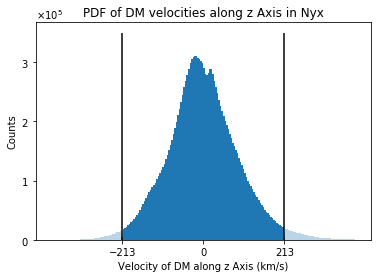

In [11]:
fig, ax = plt.subplots(1, 1)
      
ax.hist((DM_general[blnin]), bins=200, range=[-400,400]);
ax.hist((DM_general[blnout]), bins=200, range=[-400,400], color='#1f77b4', alpha=0.3);
ax.vlines(x=-thre, ymin=0, ymax=350000)
ax.vlines(x= thre, ymin=0, ymax=350000)
ax.set_title("PDF of DM velocities along z Axis in Nyx")

ax.set_xticks([-thre, 0, thre])
ax.set_xlabel('Velocity of DM along z Axis (km/s)')
ax.set_yticks([0, 1e5, 2e5, 3e5])
ax.set_ylabel('Counts')

from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter) 

In [37]:
ske = ske.reshape(-1, 250)
ske = np.exp(-ske)

In [35]:
vaxis = np.arange(0, v_end, v_end/250)

In [68]:
folder = Path.cwd() / 'test_figs_new'

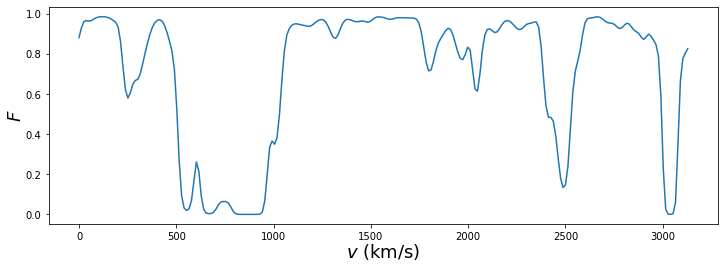

In [70]:
#ii = np.random.randint(250)
plt.figure(figsize=(12, 4))
plt.plot(vaxis, ske[ii])
plt.xlabel(r'$v$ (km/s)', fontsize=18, labelpad=0.5)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.ylabel(r'$F$', fontsize=18, labelpad=0.5)
plt.savefig(folder/'DLA.png')

In [ ]:
DM_general = load_DM(folder, DM_name)

In [4]:
import numpy as np
from test import *

In [5]:
test_vz_i = np.random.normal(scale=125, size=250)
test_DM_i = np.random.poisson(size=250)
v_step = 0.02514741843009228 * C.speed_of_light / 1e3 / 600


In [6]:
from scipy import constants as C
v_end  = 0.02514741843009228 * C.speed_of_light / 1e3 * 250 / 600
v_step = v_end/250
vz_i_shift = (test_vz_i / v_step)+0.5
vz_i_shift = np.trunc(vz_i_shift)
ind = (np.arange(250) + vz_i_shift.astype('int'))%250
DM_i_shift = np.zeros(250)
for k in range(250):
    DM_i_shift[k] = test_DM_i[ind==k].sum()

In [1]:
from test import *
from data_loader import *
test_batch = 50
def pre_proc(tau, block):
    '''log(tau), 97%'''
    tau_sum = tau.sum(axis=(-1,-2,-3))
    limit = np.percentile(tau_sum, 97)
    bln = tau_sum <= limit#np.ones(len(tau), 'bool')#
    tau = np.log(tau)
    return (tau[bln],  block[bln])

def toF_proc(tau):
    '''transfer data derived from pre_proc to F=exp(-tau)'''
    tau = np.exp(-np.exp(tau))
    return tau


folder  = Path.cwd().parent / 'Nyx'
DM_name = ['deltaDM_Nyx_L20_N160_z2.4.npy', 
            'vx_DM_Nyx_L20_N160_z2.4.npy',
            'vy_DM_Nyx_L20_N160_z2.4.npy',
            'vz_DM_Nyx_L20_N160_z2.4.npy']
ske_name_tra = 'spectra_Nyx_z2.4_z.npy'
ske_name_val = 'spectra_Nyx_z2.4_x.npy'
ske_name_tes = 'spectra_Nyx_z2.4_y.npy'



# hyper parameters
train_len  = 62500 # number of tau blocks
val_len    = 6250  # number of tau blocks
test_len   = 6250 # number of skewers
train_insize = np.array([11, 11, 59]) # x, y, z respctively
train_ousize = np.array([1, 1, 25]) # x, y, z respctively
batch_size = 50



localtime_n = ['2020-10-23 18:49:13']#localtime_n = ['']#2020-01-23 08:52:35


for localtime_i in localtime_n:
    localtime = time.strptime(localtime_i, '%Y-%m-%d %H:%M:%S')

    
    
    # device used to train the model
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    print('Using device:', torch.cuda.get_device_name(device=device.index))



    # load dark matter data
    print('Loading dark matter...')
    DM_general = load_DM(folder, DM_name).transpose(0,3,1,2)[[0,3,1,2]]
    #DM_general = (DM_general.transpose(0,2,1,3))[[0,2,1,3]][:,:,::-1,:].copy()
    DM_general = (DM_general.transpose(0,1,2,3))[[0,1,2,3]][:,::-1,::-1,:].copy()
    DM_general[1] = -DM_general[1]
    DM_general[2] = -DM_general[2]
    DM_general[0] = np.log(DM_general[0])
    # basic paramters
    DM_param.pix  = len(DM_general[0])
    DM_param.len  = 31.25 # in Mpc/h
    DM_param.reso = DM_param.len / DM_param.pix # in Mpc/h
    # test
    if DM_general.shape[1]<train_insize.min():
        raise ValueError('DarkMatter cube size',
            DM_general.shape, 'is too small for train size', train_insize, '.')
    DM_general = torch.tensor(DM_general).float()


    # load skewers
    print('Loading skewers...')
    ske, block = load_skewers(folder, ske_name_tes, train_ousize, DM_param)
    # basic parameterstest_hist
    ske_len = int(ske.shape[-1])


    # divide the sample to training, validation set, and test set.
    print('Setting test set...')
    '''
    with open("id_seperate/id_seperate_%s.txt"\
              %time.strftime("%Y-%m-%d_%H:%M:%S", localtime), "r") as f:
        aa = f.readlines()
        id_seperate = np.array(list(aa[0][::3])).astype('int')
        del aa
    f.close()
    '''
    
    id_seperate = np.append(np.ones(test_len), np.zeros(ske.shape[0]-test_len)) * 3
    np.random.shuffle(id_seperate)
    
    test_ske, test_block = load_test(ske, block, id_seperate,
                                     train_ousize, test_batch, pre_proc)
    #del id_seperate
    

    # load model
    print('Loading model...')
    model = get_residual_network().float().to(device)
    model.load_state_dict(torch.load('params/params_%s.pkl'\
            %time.strftime("%Y-%m-%d_%H:%M:%S", localtime)))
    #model.load_state_dict(torch.load('params/HyPhy_%s'\
    #        %time.strftime("%Y-%m-%d_%H:%M:%S", localtime)))



    # loss
    criterion = nn.L1Loss()

    
    # record starr time
    start_time = time.time()


    # start test
    print('Begin testing...')
    test_outp, test_losses = test(test_ske, test_block, DM_general, DM_param,
                            test_batch, train_insize, model, criterion, device, start_time)

    print("Test Summary: ")
    print("\tTest loss: {}".format(test_losses))
    
    # restore test skewers
    print('Restoring test skewers...')
    nz = (ske_len/train_ousize[2]).astype('int')
    test_outp = test_outp.reshape(-1, nz, train_ousize[0],
                                train_ousize[1], train_ousize[2])\
                                .transpose(0, 2, 3, 1, 4).reshape(-1, ske_len)
    test_ske = test_ske[:,:,0].numpy().reshape(-1, nz, train_ousize[0],
                                train_ousize[1], train_ousize[2])\
                                .transpose(0, 2, 3, 1, 4).reshape(-1, ske_len)
    test_outp = toF_proc(test_outp)
    test_ske  = toF_proc(test_ske)
    test_coord = test_block.reshape(-1, nz, 3)[:, 0, 0:2].T.reshape(2, 1, 1, -1)
    xcoor = np.arange(train_ousize[0]) - np.arange(train_ousize[0]).mean()
    ycoor = np.arange(train_ousize[1]) - np.arange(train_ousize[1]).mean()
    mesh  = np.expand_dims(np.array(np.meshgrid(xcoor, ycoor)), -1)
    test_block = (test_coord + mesh).transpose(3,2,1,0).reshape(-1, 2).astype(int)
    del test_coord, xcoor, ycoor, mesh


    print('Plotting example skewers...')
    # generate comparison images
    folder_outp = Path.cwd()/'test_figs'/('%s_zxrotate180'\
            %time.strftime("%Y-%m-%d_%H:%M:%S", localtime))
    if not os.path.exists(folder_outp):
        os.makedirs(folder_outp)
    
    
    from scipy import constants as C
    v_end  = 0.02514741843009228 * C.speed_of_light / 1e3 * DM_param.pix / 600
    F_mean = np.array([test_ske.mean(), test_outp.mean()])
    
    nrange = min(len(test_ske), 50)
    test_sp = np.arange(len(test_ske))
    np.random.seed(99)
    np.random.shuffle(test_sp)
    test_sp1 = test_sp[:int(nrange)].astype('int')
    test_sp2 = test_sp[int(nrange):].astype('int')
    
    bins = int(15)
    accuracy = AverageMeter()
    rela_err = AverageMeter()
    accu_arr = np.zeros(len(test_ske))
    erro_arr = np.zeros(len(test_ske))
    oneDPS   = np.zeros(shape=(3, len(test_ske), bins))
    
    
    # loop
    for i, ii in enumerate(test_sp1):
        print('Plotting {:{}d}/{}, z{:03d}x{:03d}.png...'\
                .format((i+1), int(np.log10(nrange)+1), nrange,
                        test_block[ii,0], test_block[ii,1]))

        test_block_i = test_block[ii]
        test_outp_i = test_outp[ii]
        test_ske_i = test_ske[ii]
        test_DM_i = DM_general[0, test_block_i[0], test_block_i[1], :].numpy()
        test_DM_i = np.exp(test_DM_i)
        test_vz_i = DM_general[3, test_block_i[0], test_block_i[1], :].numpy()

        stat_i = test_plot(test_block_i, test_outp_i, test_ske_i, test_DM_i,
                          test_vz_i, F_mean, v_end, folder_outp, bins)
        accuracy_i, rela_err_i = stat_i[[3,4]]
        accuracy.update(accuracy_i, 1)
        rela_err.update(rela_err_i, 1)
        accu_arr[ii] = accuracy_i
        erro_arr[ii] = rela_err_i
        oneDPS[:,ii] = stat_i[0], stat_i[1], stat_i[2]
    
    print('Measuring accuracy of the left skewers...')
    for i, ii in enumerate(test_sp2):
        
        test_block_i = test_block[ii]
        test_outp_i = test_outp[ii]
        test_ske_i = test_ske[ii]
        test_DM_i = DM_general[0, test_block_i[0], test_block_i[1], :].numpy()
        test_vz_i = DM_general[3, test_block_i[0], test_block_i[1], :].numpy()
        
        stat_i = test_accuracy(test_block_i, test_outp_i, test_ske_i,
                              F_mean, v_end, folder_outp, bins)
        accuracy_i, rela_err_i = stat_i[[3,4]]
        accuracy.update(accuracy_i, 1)
        rela_err.update(rela_err_i, 1)
        accu_arr[ii] = accuracy_i
        erro_arr[ii] = rela_err_i
        oneDPS[:,ii] = stat_i[0], stat_i[1], stat_i[2]
    
    
    print('Plotting average 1DPS and histogram...')
    oneDPS = oneDPS.mean(axis=1)
    oneDPS = oneDPS[~np.isnan(oneDPS)].reshape(3,-1)
    bln = oneDPS[0]<0.1
    accuracy_gen = np.abs((oneDPS[1]-oneDPS[2])/oneDPS[2])[bln].mean()
    rela_err_gen = np.abs((oneDPS[1]-oneDPS[2])/oneDPS[2])[bln].std()
    
    outp_hist, F_hist = np.histogram(test_outp, bins=np.arange(0,1.05,0.05))
    test_hist, F_hist = np.histogram(test_ske, bins=np.arange(0,1.05,0.05))
    outp_hist = np.append(outp_hist, outp_hist[-1]) / len(test_ske)
    test_hist = np.append(test_hist, test_hist[-1]) / len(test_ske)
    bln = (F_hist>=0.1) & (F_hist<0.9)
    accuracy_hist = np.abs((outp_hist-test_hist)/test_hist)[bln].mean()
    rela_err_hist = np.abs((outp_hist-test_hist)/test_hist)[bln].std()
    
    
    fig, axes = plt.subplots(2,2,figsize=(12,10))

    p0=axes[0,0].hist(accu_arr, bins=np.arange(0, 1.7, 0.1), color='grey');
    axes[0,0].set_ylim(axes[0,0].get_ylim())
    p1 = axes[0,0].vlines(x=accu_arr.mean(), ymin=0, ymax=9999, linestyle='--')
    axes[0,0].set_xlabel('accuracy $m$', fontsize=14)
    axes[0,0].set_ylabel('pdf of $m$', fontsize=14)
    axes[0,0].tick_params(labelsize=12, direction='in')
    customs = [p1, 
              Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5)]
    axes[0,0].legend(customs, ['average $m=%.4f$'%accu_arr.mean(),
                            '$N=%d$'%len(accu_arr)], fontsize=12, loc=1)

    axes[0,1].hist(erro_arr, bins=np.arange(0, 1.7, 0.1), color='grey');
    axes[0,1].set_ylim(axes[0,1].get_ylim())
    p2 = axes[0,1].vlines(x=erro_arr.mean(), ymin=0, ymax=9999, linestyle='--')
    axes[0,1].set_xlabel('error $s$', fontsize=14)
    axes[0,1].set_ylabel('pdf of $s$', fontsize=14)
    axes[0,1].tick_params(labelsize=12, direction='in')
    customs = [p2, 
              Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5)]
    axes[0,1].legend(customs, ['average $s=%.4f$'%erro_arr.mean(),
                            '$N=%d$'%len(erro_arr)], fontsize=12, loc=1)

    p3, = axes[1,0].plot(oneDPS[0], oneDPS[1], label='Predicted')
    p4, = axes[1,0].plot(oneDPS[0], oneDPS[2], label='Real', alpha=0.5)
    axes[1,0].set_xlabel(r'$k\ (\mathrm{s/km})$', fontsize=14)
    axes[1,0].set_ylabel(r'$kP_\mathrm{1D}/\pi$', fontsize=14)
    axes[1,0].set_xscale('log')
    axes[1,0].set_yscale('log')
    axes[1,0].set_ylim(axes[1,0].get_ylim())
    axes[1,0].vlines(x=0.1, ymin=1e-8, ymax=1e8)
    axes[1,0].set_title('Average 1DPS', fontsize=14)
    axes[1,0].tick_params(labelsize=12, direction='in', which='both')
    customs = [p3, p4, 
              Line2D([0], [0], marker='o', color='none',
                          markerfacecolor='k', markersize=3),
              Line2D([0], [0], marker='o', color='none',
                          markerfacecolor='k', markersize=3)]
    axes[1,0].legend(customs, [p3.get_label(), p4.get_label(), '$m=%.3f$'%accuracy_gen,
                        '$s=%.3f$'%rela_err_gen], fontsize=12)
    
    p5, = axes[1,1].step(F_hist, outp_hist, where='post', label='Predicted')
    p6, = axes[1,1].step(F_hist, test_hist, where='post', label='Real', alpha=0.5)
    axes[1,1].set_xlabel(r'$F$', fontsize=18)
    axes[1,1].set_ylabel(r'Counts', fontsize=18)
    axes[1,1].set_xlim([0, 1])
    axes[1,1].set_ylim(axes[1,1].get_ylim())
    axes[1,1].vlines(x=0.1, ymin=0, ymax=6000)
    axes[1,1].vlines(x=0.9, ymin=0, ymax=6000)
    axes[1,1].set_title('Average Histogram of $F$', fontsize=14)
    axes[1,1].tick_params(labelsize=12, direction='in')
    customs = [p5, p6, 
              Line2D([0], [0], marker='o', color='none',
                          markerfacecolor='k', markersize=3),
              Line2D([0], [0], marker='o', color='none',
                          markerfacecolor='k', markersize=3)]
    axes[1,1].legend(customs, [p5.get_label(), p6.get_label(), '$m=%.3f$'%accuracy_hist,
                        '$s=%.3f$'%rela_err_hist], fontsize=12)
    
    plt.savefig(folder_outp / ('average.png'), dpi=300, bbox_inches='tight') 
    plt.close()
    
    
    # record this test
    with open('history.txt', 'a') as f:
        f.writelines('\n\n\nTest History Record:')
        f.writelines('\n\tTest of the training at %s'\
                %time.strftime("%Y-%m-%d %H:%M:%S", localtime))
        f.writelines('\n\tTest loss: %s,  '%str(test_losses)\
            +time.strftime("%Y-%m-%d, %H:%M:%S", time.localtime()))
        f.writelines('\n\tAverage accuracy: %s,  '%str(accuracy.avg)\
            +time.strftime("%Y-%m-%d, %H:%M:%S", time.localtime()))
        f.writelines('\n\tAverage relative error: %s,  '%str(rela_err.avg)\
            +time.strftime("%Y-%m-%d, %H:%M:%S", time.localtime()))
    f.close()
    
print('Test finished!')

Using device: Quadro P5000
Loading dark matter...
Loading skewers...
Setting test set...
Loading model...
Begin testing...
Step [ 100/1212] Loss: 0.2040, Time: 6.4245
Step [ 200/1212] Loss: 0.2711, Time: 12.8181
Step [ 300/1212] Loss: 0.2471, Time: 18.6747
Step [ 400/1212] Loss: 0.1554, Time: 24.5453
Step [ 500/1212] Loss: 0.1462, Time: 30.3565
Step [ 600/1212] Loss: 0.1292, Time: 36.2465
Step [ 700/1212] Loss: 0.1044, Time: 42.0536
Step [ 800/1212] Loss: 0.1130, Time: 47.8720
Step [ 900/1212] Loss: 0.1943, Time: 53.6895
Step [1000/1212] Loss: 0.1657, Time: 59.4779
Step [1100/1212] Loss: 0.1378, Time: 65.3022
Step [1200/1212] Loss: 0.0958, Time: 71.0446
Test Summary: 
	Test loss: 0.19904999709734233
Restoring test skewers...
Plotting example skewers...
Plotting  1/50, z113x060.png...
Plotting  2/50, z135x096.png...
Plotting  3/50, z234x192.png...
Plotting  4/50, z125x077.png...
Plotting  5/50, z097x164.png...
Plotting  6/50, z216x115.png...
Plotting  7/50, z000x166.png...
Plotting  8/5

In [1]:
test_outp_exp = test_outp

NameError: name 'test_outp' is not defined

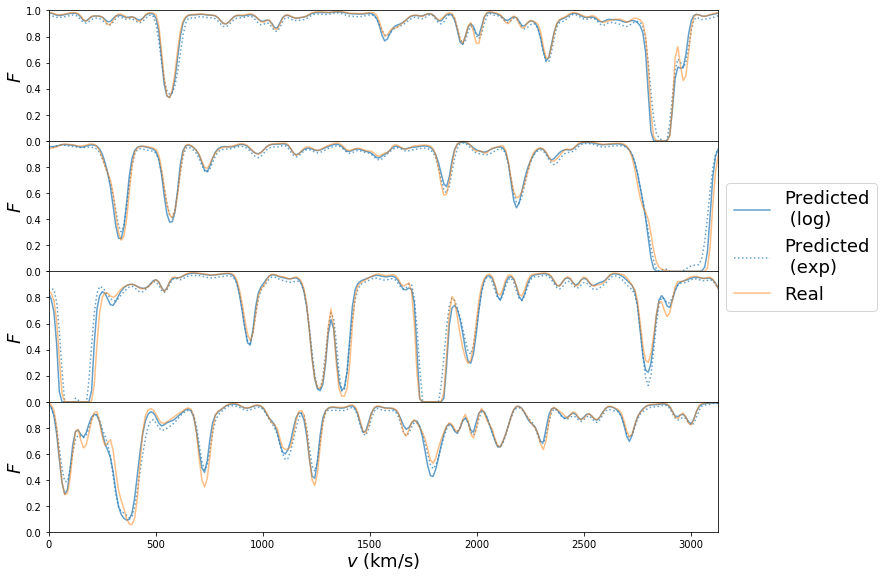

In [8]:
examples = 4
vaxis = np.arange(ske_len)/ske_len * v_end
order = np.random.randint(len(test_ske), size=examples)

fig, axes = plt.subplots(examples,1,figsize=(12,examples*2.4))

for i in range(examples):
    axes[i].plot(vaxis, test_outp_log[order[i]], label='Predicted\n (log)', alpha=0.7)
    axes[i].plot(vaxis, test_outp_exp[order[i]], label='Predicted\n (exp)', alpha=0.7, color='#1f77b4', linestyle=":")
    axes[i].plot(vaxis, test_ske[order[i]], label='Real', alpha=0.5)
    axes[i].set_xlim([0, max(vaxis)])
    axes[i].set_ylim([0,1])
    axes[i].set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8])
    axes[i].set_ylabel(r'$F$', fontsize=18, labelpad=0.5)
    if i != int(examples-1):
        axes[i].set_xticklabels([])
axes[0].set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes[-1].set_xlabel(r'$v$ (km/s)', fontsize=18, labelpad=0.5)
axes[-1].legend(fontsize=18, bbox_to_anchor=(1.25,2.75))
plt.subplots_adjust(hspace=0)
#plt.savefig(folder_outp / ('examples.png'), dpi=600, bbox_inches='tight') 

In [7]:
from scipy import constants as C
v_end  = 0.02514741843009228 * C.speed_of_light / 1e3 * DM_param.pix / 600

In [12]:
test_outp_exp = test_outp

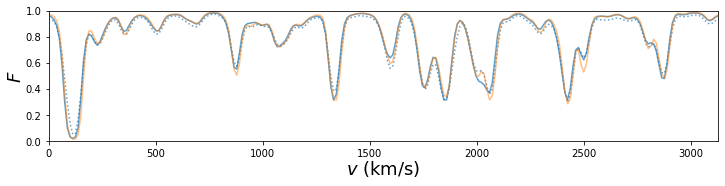

In [19]:
examples = 1
vaxis = np.arange(ske_len)/ske_len * v_end
#order = np.random.randint(len(test_ske), size=examples)

fig, axes = plt.subplots(1,1,figsize=(12, 2.4))

for i in range(1):
    axes.plot(vaxis, test_outp_log[order[i]], label='Predicted\n (log)', alpha=0.7)
    axes.plot(vaxis, test_outp_exp[order[i]], label='Predicted\n (exp)', alpha=0.7, color='#1f77b4', linestyle=":")
    axes.plot(vaxis, test_ske[order[i]], label='Real', alpha=0.5)
    axes.set_xlim([0, max(vaxis)])
    axes.set_ylim([0,1])
    axes.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8])
    axes.set_ylabel(r'$F$', fontsize=18, labelpad=0.5)
    if i != int(examples-1):
        axes.set_xticklabels([])
axes.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_xlabel(r'$v$ (km/s)', fontsize=18, labelpad=0.5)
#axes.legend(fontsize=18, bbox_to_anchor=(1.25,2.75))
plt.subplots_adjust(hspace=0)
plt.savefig('example.png', dpi=600, bbox_inches='tight') 

In [33]:
bln = oneDPS[0]<0.1
m1_log = np.abs((oneDPS1_log-oneDPS2_log)/oneDPS2_log)[bln].mean()
s1_log = np.abs((oneDPS1_log-oneDPS2_log)/oneDPS2_log)[bln].std()
m1_exp = np.abs((oneDPS1_exp-oneDPS2_log)/oneDPS2_log)[bln].mean()
s1_exp = np.abs((oneDPS1_exp-oneDPS2_log)/oneDPS2_log)[bln].std()

In [54]:
outp_hist_log = outp_hist

In [55]:
bln = (F_hist>=0.1) & (F_hist<0.9)
m2_log = np.abs((outp_hist_log-test_hist)/test_hist)[bln].mean()
s2_log = np.abs((outp_hist_log-test_hist)/test_hist)[bln].std()
m2_exp = np.abs((outp_hist_exp-test_hist)/test_hist)[bln].mean()
s2_exp = np.abs((outp_hist_exp-test_hist)/test_hist)[bln].std()

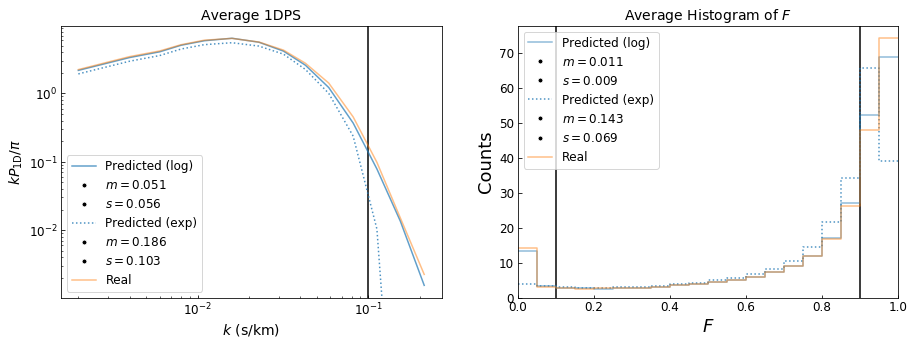

In [59]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

p1, = axes[0].plot(oneDPS[0], oneDPS1_log, label='Predicted (log)', alpha=0.7)
p3, = axes[0].plot(oneDPS[0], oneDPS2_log, label='Real', alpha=0.5)
axes[0].set_xlabel(r'$k\ (\mathrm{s/km})$', fontsize=14)
axes[0].set_ylabel(r'$kP_\mathrm{1D}/\pi$', fontsize=14)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_ylim(axes[0].get_ylim())
p2, = axes[0].plot(oneDPS[0], oneDPS1_exp, label='Predicted (exp)', alpha=0.8, color='#1f77b4', linestyle=":")
axes[0].vlines(x=0.1, ymin=1e-8, ymax=1e8)
axes[0].set_title('Average 1DPS', fontsize=14)
axes[0].tick_params(labelsize=12, direction='in', which='both')
customs = [p1,
          Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5),
          Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5),
          p2,
          Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5),
          Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5),
          p3]
axes[0].legend(customs, [p1.get_label(), '$m=%.3f$'%m1_log, '$s=%.3f$'%s1_log,
                         p2.get_label(), '$m=%.3f$'%m1_exp, '$s=%.3f$'%s1_exp,
                         p3.get_label(), ], fontsize=12)

p4, = axes[1].step(F_hist, outp_hist_log, where='post', label='Predicted (log)', alpha=0.5)
p5, = axes[1].step(F_hist, outp_hist_exp, where='post', label='Predicted (exp)', alpha=0.8, color='#1f77b4', linestyle=":")
p6, = axes[1].step(F_hist, test_hist, where='post', label='Real', alpha=0.5)
axes[1].set_xlabel(r'$F$', fontsize=18)
axes[1].set_ylabel(r'Counts', fontsize=18)
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, axes[1].get_ylim()[1]])
axes[1].vlines(x=0.1, ymin=0, ymax=6000)
axes[1].vlines(x=0.9, ymin=0, ymax=6000)
axes[1].set_title('Average Histogram of $F$', fontsize=14)
axes[1].tick_params(labelsize=12, direction='in')
customs = [p4,
          Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5),
          Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5),
          p5,
          Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5),
          Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5),
          p6]
axes[1].legend(customs, [p4.get_label(), '$m=%.3f$'%m2_log, '$s=%.3f$'%s2_log,
                         p5.get_label(), '$m=%.3f$'%m2_exp, '$s=%.3f$'%s2_exp,
                         p6.get_label(), ], fontsize=12)

plt.savefig(folder_outp / ('average_comp.png'), dpi=300, bbox_inches='tight') 

In [5]:
test_outp.shape

(605, 250)

In [11]:
for i in range(20):
    print('params/params_%s_%d.pkl'%(time.strftime("%Y-%m-%d_%H:%M:%S", localtime), i))

params/params_2020-01-23_08:52:35_0.pkl
params/params_2020-01-23_08:52:35_1.pkl
params/params_2020-01-23_08:52:35_2.pkl
params/params_2020-01-23_08:52:35_3.pkl
params/params_2020-01-23_08:52:35_4.pkl
params/params_2020-01-23_08:52:35_5.pkl
params/params_2020-01-23_08:52:35_6.pkl
params/params_2020-01-23_08:52:35_7.pkl
params/params_2020-01-23_08:52:35_8.pkl
params/params_2020-01-23_08:52:35_9.pkl
params/params_2020-01-23_08:52:35_10.pkl
params/params_2020-01-23_08:52:35_11.pkl
params/params_2020-01-23_08:52:35_12.pkl
params/params_2020-01-23_08:52:35_13.pkl
params/params_2020-01-23_08:52:35_14.pkl
params/params_2020-01-23_08:52:35_15.pkl
params/params_2020-01-23_08:52:35_16.pkl
params/params_2020-01-23_08:52:35_17.pkl
params/params_2020-01-23_08:52:35_18.pkl
params/params_2020-01-23_08:52:35_19.pkl


In [1]:
from test import *
from data_loader import *
test_batch = 50
def pre_proc(tau, block):
    '''log(tau), 97%'''
    tau_sum = tau.sum(axis=(-1,-2,-3))
    limit = np.percentile(tau_sum, 97)
    bln = tau_sum <= limit#np.ones(len(tau), 'bool')#
    tau = np.log(tau)#1-np.exp(-tau)
    return (tau[bln],  block[bln])

def toF_proc(tau):
    '''transfer data derived from pre_proc to F=exp(-tau)'''
    tau = np.exp(-np.exp(tau))
    return tau


folder  = Path.cwd().parent / 'Nyx'
DM_name = ['deltaDM_Nyx_L20_N160_z2.4.npy', 
            'vx_DM_Nyx_L20_N160_z2.4.npy',
            'vy_DM_Nyx_L20_N160_z2.4.npy',
            'vz_DM_Nyx_L20_N160_z2.4.npy']
ske_name_tra = 'spectra_Nyx_z2.4_z.npy'
ske_name_val = 'spectra_Nyx_z2.4_x.npy'
ske_name_tes = 'spectra_Nyx_z2.4_z.npy'



# hyper parameters
train_len  = 62500 # number of tau blocks
val_len    = 6250  # number of tau blocks
test_len   = 625  # number of skewers
train_insize = np.array([11, 11, 93]) # x, y, z respctively
train_ousize = np.array([1, 1, 25]) # x, y, z respctively
batch_size = 50

id_seperate = np.append(np.ones(test_len), np.zeros(62500-test_len)) * 3
np.random.shuffle(id_seperate)

localtime_n = ['2020-06-04 01:01:40']
skes = np.zeros(shape=(30, 605, 250))

#for localtime_i in localtime_n:
localtime_i = localtime_n[0]
for i in range(30):
    localtime = time.strptime(localtime_i, '%Y-%m-%d %H:%M:%S')
    
    
    # device used to train the model
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    print('Using device:', torch.cuda.get_device_name(device=device.index))



    # load dark matter data
    print('Loading dark matter...')
    DM_general = load_DM(folder, DM_name)#.transpose(0,3,1,2)[[0,3,1,2]]
    # basic paramters
    DM_param.pix  = len(DM_general[0])
    DM_param.len  = 31.25 # in Mpc/h
    DM_param.reso = DM_param.len / DM_param.pix # in Mpc/h
    # test
    if DM_general.shape[1]<train_insize.min():
        raise ValueError('DarkMatter cube size',
            DM_general.shape, 'is too small for train size', train_insize, '.')
    DM_general = torch.tensor(DM_general).float()


    # load skewers
    print('Loading skewers...')
    ske, block = load_skewers(folder, ske_name_tes, train_ousize, DM_param)
    # basic parameterstest_hist
    ske_len = int(ske.shape[-1])

    # divide the sample to training, validation set, and test set.
    print('Setting test set...')
    
    
    test_ske, test_block = load_test(ske, block, id_seperate,
                                     train_ousize, test_batch, pre_proc)
    #del id_seperate


    # load model
    print('Loading model...')
    model = get_residual_network().float().to(device)
    model.load_state_dict(torch.load('params/4Defense/HyPhy_%s_%d_%d'%(time.strftime("%Y-%m-%d_%H:%M:%S", localtime), 0, int((i+1)*400))))
    #model.load_state_dict(torch.load('params/HyPhy_%s'\
    #        %time.strftime("%Y-%m-%d_%H:%M:%S", localtime)))



    # loss
    criterion = nn.L1Loss()

    
    # record starr time
    start_time = time.time()


    # start test
    print('Begin testing...')
    test_outp, test_losses = test(test_ske, test_block, DM_general, DM_param,
                            test_batch, train_insize, model, criterion, device, start_time)

    print("Test Summary: ")
    print("\tTest loss: {}".format(test_losses))
    
    # restore test skewers
    print('Restoring test skewers...')
    nz = (ske_len/train_ousize[2]).astype('int')
    test_outp = test_outp.reshape(-1, nz, train_ousize[0],
                                train_ousize[1], train_ousize[2])\
                                .transpose(0, 2, 3, 1, 4).reshape(-1, ske_len)
    test_ske = test_ske[:,:,0].numpy().reshape(-1, nz, train_ousize[0],
                                train_ousize[1], train_ousize[2])\
                                .transpose(0, 2, 3, 1, 4).reshape(-1, ske_len)
    test_outp = toF_proc(test_outp)
    test_ske  = toF_proc(test_ske)
    test_coord = test_block.reshape(-1, nz, 3)[:, 0, 0:2].T.reshape(2, 1, 1, -1)
    xcoor = np.arange(train_ousize[0]) - np.arange(train_ousize[0]).mean()
    ycoor = np.arange(train_ousize[1]) - np.arange(train_ousize[1]).mean()
    mesh  = np.expand_dims(np.array(np.meshgrid(xcoor, ycoor)), -1)
    test_block = (test_coord + mesh).transpose(3,2,1,0).reshape(-1, 2).astype(int)
    del test_coord, xcoor, ycoor, mesh


    print('Plotting example skewers...')
    # generate comparison images
    folder_outp = Path.cwd()/'test_figs_new'/('%s'\
            %time.strftime("%Y-%m-%d_%H:%M:%S", localtime))
    if not os.path.exists(folder_outp):
        os.makedirs(folder_outp)
    
    skes[i] = test_outp
    
    '''
    from scipy import constants as C
    v_end  = 0.02514741843009228 * C.speed_of_light / 1e3 * DM_param.pix / 600
    F_mean = np.array([test_ske.mean(), test_outp.mean()])
    
    nrange = min(len(test_ske), 50)
    test_sp = np.arange(len(test_ske))
    np.random.seed(99)
    np.random.shuffle(test_sp)
    test_sp1 = test_sp[:int(nrange)].astype('int')
    test_sp2 = test_sp[int(nrange):].astype('int')
    
    bins = int(15)
    accuracy = AverageMeter()
    rela_err = AverageMeter()
    accu_arr = np.zeros(len(test_ske))
    erro_arr = np.zeros(len(test_ske))
    oneDPS   = np.zeros(shape=(3, len(test_ske), bins))
    
    
    # loop
    for i, ii in enumerate(test_sp1):
        print('Plotting {:{}d}/{}, x{:03d}y{:03d}.png...'\
                .format((i+1), int(np.log10(nrange)+1), nrange,
                        test_block[ii,0], test_block[ii,1]))

        test_block_i = test_block[ii]
        test_outp_i = test_outp[ii]
        test_ske_i = test_ske[ii]
        test_DM_i = DM_general[0, test_block_i[0], test_block_i[1], :].numpy()

        stat_i = test_plot(test_block_i, test_outp_i, test_ske_i,
                          test_DM_i, F_mean, v_end, folder_outp, bins)
        accuracy_i, rela_err_i = stat_i[[3,4]]
        accuracy.update(accuracy_i, 1)
        rela_err.update(rela_err_i, 1)
        accu_arr[ii] = accuracy_i
        erro_arr[ii] = rela_err_i
        oneDPS[:,ii] = stat_i[0], stat_i[1], stat_i[2]
    
    print('Measuring accuracy of the left skewers...')
    for i, ii in enumerate(test_sp2):
        
        test_block_i = test_block[ii]
        test_outp_i = test_outp[ii]
        test_ske_i = test_ske[ii]
        test_DM_i = DM_general[0, test_block_i[0], test_block_i[1], :].numpy()
        
        stat_i = test_accuracy(test_block_i, test_outp_i, test_ske_i,
                              F_mean, v_end, folder_outp, bins)
        accuracy_i, rela_err_i = stat_i[[3,4]]
        accuracy.update(accuracy_i, 1)
        rela_err.update(rela_err_i, 1)
        accu_arr[ii] = accuracy_i
        erro_arr[ii] = rela_err_i
        oneDPS[:,ii] = stat_i[0], stat_i[1], stat_i[2]
    
    
    print('Plotting average 1DPS and histogram...')
    oneDPS = oneDPS.mean(axis=1)
    oneDPS = oneDPS[~np.isnan(oneDPS)].reshape(3,-1)
    bln = oneDPS[0]<0.1
    accuracy_gen = np.abs((oneDPS[1]-oneDPS[2])/oneDPS[2])[bln].mean()
    rela_err_gen = np.abs((oneDPS[1]-oneDPS[2])/oneDPS[2])[bln].std()
    
    outp_hist, F_hist = np.histogram(test_outp, bins=np.arange(0,1.05,0.05))
    test_hist, F_hist = np.histogram(test_ske, bins=np.arange(0,1.05,0.05))
    outp_hist = np.append(outp_hist, outp_hist[-1]) / len(test_ske)
    test_hist = np.append(test_hist, test_hist[-1]) / len(test_ske)
    bln = (F_hist>=0.1) & (F_hist<0.9)
    accuracy_hist = np.abs((outp_hist-test_hist)/test_hist)[bln].mean()
    rela_err_hist = np.abs((outp_hist-test_hist)/test_hist)[bln].std()
    
    
    fig, axes = plt.subplots(2,2,figsize=(12,10))

    p0=axes[0,0].hist(accu_arr, bins=np.arange(0, 1.7, 0.1), color='grey');
    axes[0,0].set_ylim(axes[0,0].get_ylim())
    p1 = axes[0,0].vlines(x=accu_arr.mean(), ymin=0, ymax=9999, linestyle='--')
    axes[0,0].set_xlabel('accuracy $m$', fontsize=14)
    axes[0,0].set_ylabel('pdf of $m$', fontsize=14)
    axes[0,0].tick_params(labelsize=12, direction='in')
    customs = [p1, 
              Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5)]
    axes[0,0].legend(customs, ['average $m=%.4f$'%accu_arr.mean(),
                            '$N=%d$'%len(accu_arr)], fontsize=12, loc=1)

    axes[0,1].hist(erro_arr, bins=np.arange(0, 1.7, 0.1), color='grey');
    axes[0,1].set_ylim(axes[0,1].get_ylim())
    p2 = axes[0,1].vlines(x=erro_arr.mean(), ymin=0, ymax=9999, linestyle='--')
    axes[0,1].set_xlabel('error $s$', fontsize=14)
    axes[0,1].set_ylabel('pdf of $s$', fontsize=14)
    axes[0,1].tick_params(labelsize=12, direction='in')
    customs = [p2, 
              Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5)]
    axes[0,1].legend(customs, ['average $s=%.4f$'%erro_arr.mean(),
                            '$N=%d$'%len(erro_arr)], fontsize=12, loc=1)

    p3, = axes[1,0].plot(oneDPS[0], oneDPS[1], label='Predicted')
    p4, = axes[1,0].plot(oneDPS[0], oneDPS[2], label='Real', alpha=0.5)
    axes[1,0].set_xlabel(r'$k\ (\mathrm{s/km})$', fontsize=14)
    axes[1,0].set_ylabel(r'$kP_\mathrm{1D}/\pi$', fontsize=14)
    axes[1,0].set_xscale('log')
    axes[1,0].set_yscale('log')
    axes[1,0].set_ylim(axes[1,0].get_ylim())
    axes[1,0].vlines(x=0.1, ymin=1e-8, ymax=1e8)
    axes[1,0].set_title('Average 1DPS', fontsize=14)
    axes[1,0].tick_params(labelsize=12, direction='in', which='both')
    customs = [p3, p4, 
              Line2D([0], [0], marker='o', color='none',
                          markerfacecolor='k', markersize=3),
              Line2D([0], [0], marker='o', color='none',
                          markerfacecolor='k', markersize=3)]
    axes[1,0].legend(customs, [p3.get_label(), p4.get_label(), '$m=%.3f$'%accuracy_gen,
                        '$s=%.3f$'%rela_err_gen], fontsize=12)
    
    p5, = axes[1,1].step(F_hist, outp_hist, where='post', label='Predicted')
    p6, = axes[1,1].step(F_hist, test_hist, where='post', label='Real', alpha=0.5)
    axes[1,1].set_xlabel(r'$F$', fontsize=18)
    axes[1,1].set_ylabel(r'Counts', fontsize=18)
    axes[1,1].set_xlim([0, 1])
    axes[1,1].set_ylim(axes[1,1].get_ylim())
    axes[1,1].vlines(x=0.1, ymin=0, ymax=6000)
    axes[1,1].vlines(x=0.9, ymin=0, ymax=6000)
    axes[1,1].set_title('Average Histogram of $F$', fontsize=14)
    axes[1,1].tick_params(labelsize=12, direction='in')
    customs = [p5, p6, 
              Line2D([0], [0], marker='o', color='none',
                          markerfacecolor='k', markersize=3),
              Line2D([0], [0], marker='o', color='none',
                          markerfacecolor='k', markersize=3)]
    axes[1,1].legend(customs, [p5.get_label(), p6.get_label(), '$m=%.3f$'%accuracy_hist,
                        '$s=%.3f$'%rela_err_hist], fontsize=12)
    
    plt.savefig(folder_outp / ('average.png'), dpi=300, bbox_inches='tight') 
    plt.close()
    
    
    # record this test
    with open('history.txt', 'a') as f:
        f.writelines('\n\n\nTest History Record:')
        f.writelines('\n\tTest of the training at %s'\
                %time.strftime("%Y-%m-%d %H:%M:%S", localtime))
        f.writelines('\n\tTest loss: %s,  '%str(test_losses)\
            +time.strftime("%Y-%m-%d, %H:%M:%S", time.localtime()))
        f.writelines('\n\tAverage accuracy: %s,  '%str(accuracy.avg)\
            +time.strftime("%Y-%m-%d, %H:%M:%S", time.localtime()))
        f.writelines('\n\tAverage relative error: %s,  '%str(rela_err.avg)\
            +time.strftime("%Y-%m-%d, %H:%M:%S", time.localtime()))
    f.close()
    '''
np.save(Path.cwd()/'test_figs_new/Process_test', skes)
np.save(Path.cwd()/'test_figs_new/Process_refe', test_ske)
print('Test finished!')

Using device: Quadro P5000
Loading dark matter...
Loading skewers...
Setting test set...
Loading model...
Begin testing...
Step [100/121] Loss: 0.7630, Time: 10.0666
Test Summary: 
	Test loss: 0.6791039636312437
Restoring test skewers...
Plotting example skewers...
Using device: Quadro P5000
Loading dark matter...
Loading skewers...
Setting test set...
Loading model...
Begin testing...
Step [100/121] Loss: 0.4588, Time: 10.2631
Test Summary: 
	Test loss: 0.4408170477417875
Restoring test skewers...
Plotting example skewers...
Using device: Quadro P5000
Loading dark matter...
Loading skewers...
Setting test set...
Loading model...
Begin testing...
Step [100/121] Loss: 0.6509, Time: 9.7013
Test Summary: 
	Test loss: 0.6012853263330854
Restoring test skewers...
Plotting example skewers...
Using device: Quadro P5000
Loading dark matter...
Loading skewers...
Setting test set...
Loading model...
Begin testing...
Step [100/121] Loss: 0.6154, Time: 9.9240
Test Summary: 
	Test loss: 0.572778702

In [2]:
skes.shape

(30, 605, 250)

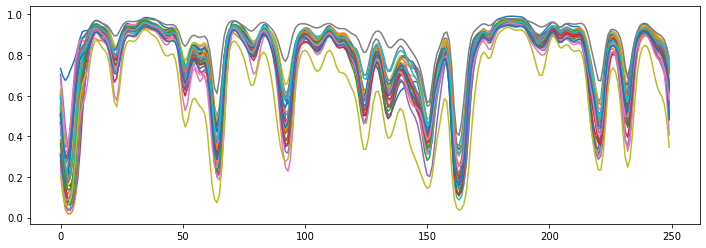

In [2]:
ii = np.random.randint(605)
plt.figure(figsize=(12, 4))
plt.plot(test_ske[ii])
for i in range(30):
    plt.plot(skes[i, ii])